In [ ]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [ ]:
#extract the files from the zip file
import zipfile
z = zipfile.ZipFile('image.zip')
z.extractall()

In [ ]:
#Rename the files in the subfolder yes and no of brain_tumour_dataset
#Yes = tumorous
#No = non-tumorous
#Rename the yes folder files using Y_1 and so on
folder = 'brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "Y_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print('All files are renamed in the Yes directory')

All files are renamed in the Yes directory


In [ ]:
##Rename the no folder files using N_1 and so on
folder = 'brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
  source = folder + filename
  destination = folder + "N_" + str(count) + ".jpg"
  os.rename(source, destination)
  count += 1
print('All files are renamed in the No directory')

All files are renamed in the No directory


In [ ]:
#Exploring the dataset
#How many numbers of the files are tumorous

listyes = os.listdir('brain_tumor_dataset/yes/')
number_files_yes = len(listyes)
print(number_files_yes)

155


In [ ]:
#How many numbers of the files are non-tumorous
listno = os.listdir('brain_tumor_dataset/no/')
number_files_no = len(listno)
print(number_files_no)

98


In [ ]:
#Percentage of tumorous and non-tumorous
T = (number_files_yes * 100 )/(number_files_yes+number_files_no)
print(f"Percentage of tumorous data: {T}%")
N = (number_files_no * 100) /(number_files_yes+number_files_no)
print(f"Percentage of non-tumorous data: {N}%")

Percentage of tumorous data: 61.26482213438735%
Percentage of non-tumorous data: 38.73517786561265%


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
def augmented_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i+=1
            if i>n_generated_samples:
                break

In [ ]:
#Creation of balance dataset from the imbalance dataset in the augmented_data folder
yes_path = 'brain_tumor_dataset/yes'
no_path = 'brain_tumor_dataset/no'

augmented_data_path = 'augmented_data/'

augmented_data(file_dir = yes_path,n_generated_samples = 6,save_to_dir = augmented_data_path+'yes')
augmented_data(file_dir = no_path,n_generated_samples = 9,save_to_dir = augmented_data_path+'no')

In [ ]:
def data_summary(main_path):
  yes_path = 'augmented_data/yes/'
  no_path = 'augmented_data/no/'

  n_pos = len(os.listdir(yes_path))
  n_neg = len(os.listdir(no_path))

  n = (n_pos + n_neg)

  pos_per = (n_pos*100)/n
  neg_per = (n_neg*100)/n


  print(f"Number of samples: {n}")
  print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
  print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

In [ ]:
data_summary(augmented_data_path)

Number of samples: 2063
1084 Number of positive sample in percentage: 52.544837615123605%
979 Number of negative sample in percentage: 47.455162384876395%


In [ ]:
listyes = os.listdir("augmented_data/yes/")
number_files_yes = len(listyes)
print(number_files_yes)

listno = os.listdir("augmented_data/no/")
number_files_no = len(listno)
print(number_files_no)

1084
979


In [ ]:
#Data preprocessing
# Convert BGR TO GRAY
# GaussianBlur
# Threshold
# Erode
# Dilate
# Find Contours

In [ ]:
import imutils
def crop_brain_tumor(image, plot=False):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  gray = cv2.GaussianBlur(gray, (5,5), 0)

  thres = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thres = cv2.erode(thres, None, iterations = 2)
  thres = cv2.dilate(thres, None, iterations = 2)

  cnts = cv2.findContours(thres.copy(),cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts,key=cv2.contourArea)

  extLeft = tuple(c[c[:,:,0].argmin()][0])
  extRight = tuple(c[c[:,:,0].argmax()][0])
  extTop = tuple(c[c[:,:,1].argmin()][0])
  extBot = tuple(c[c[:,:,1].argmax()][0])


  new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

  if plot:
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(image)

    plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(new_image)

    plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    plt.title('Cropped Image')
    plt.show()
  return new_image




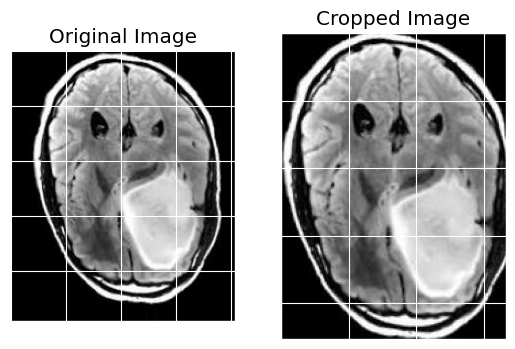

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
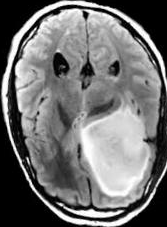

In [ ]:
img = cv2.imread('augmented_data/yes/aug_Y_100_0_5033.jpg')
crop_brain_tumor(img, True)

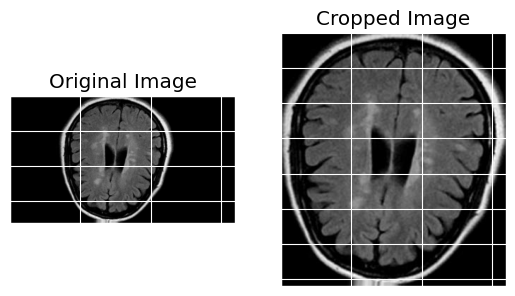

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
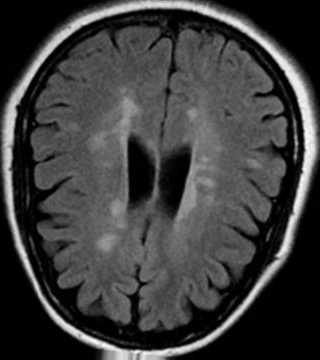

In [ ]:
img = cv2.imread('augmented_data/no/aug_N_10_0_3023.jpg')
crop_brain_tumor(img, True)

In [ ]:
folder1 = 'augmented_data/no/'
folder2 = 'augmented_data/yes/'

for filename in os.listdir(folder1):
  img = cv2.imread(folder1 + filename)
  img = crop_brain_tumor(img, False)
  cv2.imwrite(folder1 + filename,img)

for filename in os.listdir(folder2):
  img = cv2.imread(folder2 + filename)
  img = crop_brain_tumor(img, False)
  cv2.imwrite(folder2 + filename,img)

In [ ]:
from sklearn.utils import shuffle
#Load the image

def load_data(dir_list, image_size):
  X=[]
  y=[]
  image_width, image_height = image_size


  for directory in dir_list:
    for filename in os.listdir(directory):
      image = cv2.imread(directory + '/' + filename)
      image = crop_brain_tumor(image,plot = False)
      image = cv2.resize(image, dsize=(image_width, image_height),interpolation=cv2.INTER_CUBIC)
      image = image / 255.00
      X.append(image)

      if directory[-3:] == 'yes':
        y.append(1)
      else:
        y.append(0)

    X = np.array(X)
    y = np.array(y)

    X,y = shuffle(X,y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X,y



In [ ]:
augmented_path = 'augmented_data/'
augmented_yes = 'augmented_data/yes'
augmented_no = 'augmented_data/no'

IMAGE_WIDTH, IMAGE_HEIGHT = (240,240)

X,y = load_data([augmented_yes, augmented_no], (IMAGE_WIDTH, IMAGE_HEIGHT))

Number of example is : 1084
X SHAPE is : (1084, 240, 240, 3)
y SHAPE is : (1084,)


In [ ]:
#Create the directories for train, test and validation
if not os.path.isdir('tumorous_and_nontumorous'):
  base_dir = 'tumorous_and_nontumorous'
  os.mkdir(base_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)

In [ ]:
if not os.path.isdir('tumorous_and_nontumorous/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('tumorous_and_nontumorous/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('tumorous_and_nontumorous/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [ ]:
#Define the tumorous and non-tumorous for further processing
original_dataset_tumorours = os.path.join('augmented_data','yes/')
original_dataset_nontumorours = os.path.join('augmented_data','no/')

In [ ]:
#src = source #dst = destination #training
files = os.listdir('augmented_data/yes')
fnames = []
for i in range(0,759):
  fnames.append(files[i])
for fname in fnames:
  src = os.path.join(original_dataset_tumorours,fname)
  dst = os.path.join(infected_train_dir, fname)
  shutil.copyfile(src, dst)

In [ ]:
#test
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(759,922):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
#validation
files = os.listdir('augmented_data/yes/')
fnames = []
for i in range(922,1084):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(0,686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(686,833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
files = os.listdir('augmented_data/no/')
fnames = []
for i in range(833,978):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

In [ ]:
#80 % was taken as train, 10 % as test and 10 % as validation

In [ ]:
#Model Builiding

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0/255)
valid_data_gen = ImageDataGenerator(rescale=1.0/255)

In [ ]:
train_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/train/',batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 1445 images belonging to 2 classes.


In [ ]:
test_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [ ]:
valid_generator = train_datagen.flow_from_directory('tumorous_and_nontumorous/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 307 images belonging to 2 classes.


In [ ]:
class_labels = train_generator.class_indices

In [ ]:
class_labels

{'nontumorous': 0, 'tumorous': 1}

In [ ]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable=False

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_01 = Model(base_model.input, output)
model_01.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# callback
filepath = 'model.keras'
es = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
cp = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=False, mode='auto',save_freq='epoch')
lrr = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_01.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history_01 = model_01.fit(train_generator, steps_per_epoch=10, epochs = 5, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.5112 - loss: 0.7768
Epoch 1: val_loss improved from inf to 0.68555, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step - accuracy: 0.5108 - loss: 0.7757 - val_accuracy: 0.5342 - val_loss: 0.6855 - learning_rate: 1.0000e-04
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - accuracy: 0.5121 - loss: 0.7438
Epoch 2: val_loss did not improve from 0.68555
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5122 - loss: 0.7418 - val_accuracy: 0.5277 - val_loss: 0.6948 - learning_rate: 1.0000e-04
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.5455 - loss: 0.6984
Epoch 3: val_loss did not improve from 0.68555
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5448 - loss: 0.6991 - val_accuracy: 0.5375 - val_loss: 0.6878 - learning_rate: 1.0000e-04
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 845ms/step - accuracy: 0.5092 - loss: 0.7073
Epoch 4: val_loss improved from 0.68555 to 0.66172, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.5101 - loss: 0.7073 - val_accuracy: 0.6221 - val_loss: 0.6617 - learning_rate: 1.0000e-04
Epoch 5/5
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 0.4973 - loss: 0.6996

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 5: val_loss improved from 0.66172 to 0.64932, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.5026 - loss: 0.6961 - val_accuracy: 0.5993 - val_loss: 0.6493 - learning_rate: 1.0000e-04


In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_01.save_weights(filepath="model_weights/vgg19_model_01.weights.h5", overwrite=True)

In [ ]:
model_01.load_weights("model_weights/vgg19_model_01.weights.h5")
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 471ms/step - accuracy: 0.5799 - loss: 0.6639
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5779 - loss: 0.6686


In [ ]:
print(f'Validation Loss: {vgg_val_eval_01[0]}')
print(f'Validation Acc: {vgg_val_eval_01[1]}')
print(f'Testing Loss: {vgg_test_eval_01[0]}')
print(f'Testing Acc: {vgg_test_eval_01[1]}')

Validation Loss: 0.6665967106819153
Validation Acc: 0.5765472054481506
Testing Loss: 0.6591655611991882
Testing Acc: 0.6225806474685669


In [ ]:
filenames = test_generator.filenames
nb_sample = len(filenames)

vgg_prediction_01 = model_01.predict(test_generator, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction_01, axis=1)

310/310 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step   


In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_02 = Model(base_model.inputs, output)
model_02.load_weights('model_weights/vgg19_model_01.weights.h5')

set_trainable=False
for layer in base_model.layers:
    if layer.name in ['block5_conv4','block5_conv3']:
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False

print(model_02.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 125,641,602 (479.28 MB)

 Non-trainable params: 15,304,768 (58.38 MB)

None


In [ ]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_02.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
history_02 = model_02.fit(train_generator, steps_per_epoch=20, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 689ms/step - accuracy: 0.5686 - loss: 0.6893
Epoch 1: val_loss improved from 0.64932 to 0.64407, saving model to model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.5692 - loss: 0.6889 - val_accuracy: 0.6156 - val_loss: 0.6441 - learning_rate: 1.0000e-04
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.5914 - loss: 0.6592
Epoch 2: val_loss did not improve from 0.64407
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 815ms/step - accuracy: 0.5927 - loss: 0.6587 - val_accuracy: 0.6254 - val_loss: 0.6571 - learning_rate: 1.0000e-04
Epoch 3/10
 6/20 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.6321 - loss: 0.6504
Epoch 3: val_loss improved from 0.64407 to 0.62865, saving model to model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6235 - loss: 0.6503 - val_accuracy: 0.6580 - val_loss: 0.6286 - learning_rate: 1.0000e-04
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 572ms/step - accuracy: 0.6374 - loss: 0.6356
Epoch 4: val_loss

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_02.save_weights(filepath="model_weights/vgg19_model_02.weights.h5", overwrite=True)

In [ ]:
model_02.load_weights("model_weights/vgg19_model_02.weights.h5")
vgg_val_eval_02 = model_02.evaluate(valid_generator)
vgg_test_eval_02 = model_02.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 566ms/step - accuracy: 0.6555 - loss: 0.6103
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 578ms/step - accuracy: 0.6487 - loss: 0.5855


In [ ]:
# Unfreezing the entire network

In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_03 = Model(base_model.inputs, output)
model_03.load_weights('model_weights/vgg19_model_02.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_03.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

In [ ]:
model_03.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_03 = model_03.fit(train_generator, steps_per_epoch=10, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.8396 - loss: 0.3745
Epoch 1: val_loss improved from 0.36896 to 0.35523, saving model to model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 48s 5s/step - accuracy: 0.8423 - loss: 0.3716 - val_accuracy: 0.8241 - val_loss: 0.3552 - learning_rate: 1.0000e-04
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 828ms/step - accuracy: 0.8618 - loss: 0.3114
Epoch 2: val_loss did not improve from 0.35523
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.8616 - loss: 0.3145 - val_accuracy: 0.8176 - val_loss: 0.3616 - learning_rate: 1.0000e-04
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8061 - loss: 0.4198
Epoch 3: val_loss did not improve from 0.35523
10/10 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.8084 - loss: 0.4153 - val_accuracy: 0.8436 - val_loss: 0.3676 - learning_rate: 1.0000e-04
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.8574 - loss: 0.3224
Epoch 4: val_loss improved from 0.35523 to 0.31304, s

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_03.save_weights(filepath="model_weights/vgg19_model_03.weights.h5", overwrite=True)

In [ ]:
model_03.load_weights("model_weights/vgg19_model_03.weights.h5")
vgg_val_eval_03 = model_03.evaluate(valid_generator)
vgg_test_eval_03 = model_03.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 625ms/step - accuracy: 0.8794 - loss: 0.3248
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 694ms/step - accuracy: 0.8549 - loss: 0.3116


In [ ]:
print(f'Validation Loss: {vgg_val_eval_03[0]}')
print(f'Validation Acc: {vgg_val_eval_03[1]}')
print(f'Testing Loss: {vgg_test_eval_03[0]}')
print(f'Testing Acc: {vgg_test_eval_03[1]}')

Validation Loss: 0.30475008487701416
Validation Acc: 0.8762214779853821
Testing Loss: 0.3084857761859894
Testing Acc: 0.85161292552948


In [ ]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers]
base_model_layer_names

x=base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_04 = Model(base_model.inputs, output)
model_04.load_weights('model_weights/vgg19_model_03.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_04.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
model_04.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 240, 240, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 240, 240, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 120, 120, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 120, 120, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 120, 120, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 60, 60, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 60, 60, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 30, 30, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 30, 30, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 15, 15, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 15, 15, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_04 = model_04.fit(train_generator, steps_per_epoch=15, epochs = 10, callbacks=[es,cp,lrr], validation_data=valid_generator)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - accuracy: 0.8947 - loss: 0.2523
Epoch 1: val_loss did not improve from 0.23283
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8940 - loss: 0.2524 - val_accuracy: 0.8860 - val_loss: 0.2781 - learning_rate: 1.0000e-04
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 760ms/step - accuracy: 0.9093 - loss: 0.2308
Epoch 2: val_loss improved from 0.23283 to 0.21457, saving model to model.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 65s 5s/step - accuracy: 0.9094 - loss: 0.2297 - val_accuracy: 0.9088 - val_loss: 0.2146 - learning_rate: 1.0000e-04
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.9044 - loss: 0.2057
Epoch 3: val_loss did not improve from 0.21457
15/15 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.9039 - loss: 0.2068 - val_accuracy: 0.9023 - val_loss: 0.2341 - learning_rate: 1.0000e-04
Epoch 4/10
 1/15 ━━━━━━━━━━━━━━━━━━━━ 10s 755ms/step - accuracy: 0.9062 - loss: 0.1596
Epoch 4: val_loss did not improve from 0.21457
15/15

In [ ]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_04.save_weights(filepath="model_weights/vgg19_model_04.weights.h5", overwrite=True)

In [ ]:
model_04.load_weights("model_weights/vgg19_model_04.weights.h5")
vgg_val_eval_04 = model_04.evaluate(valid_generator)
vgg_test_eval_04 = model_04.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 458ms/step - accuracy: 0.9092 - loss: 0.2102
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 637ms/step - accuracy: 0.8684 - loss: 0.2585


In [ ]:
print(f'Validation Loss: {vgg_val_eval_04[0]}')
print(f'Validation Acc: {vgg_val_eval_04[1]}')
print(f'Testing Loss: {vgg_test_eval_04[0]}')
print(f'Testing Acc: {vgg_test_eval_04[1]}')

Validation Loss: 0.23839685320854187
Validation Acc: 0.895765483379364
Testing Loss: 0.2736576795578003
Testing Acc: 0.8677419424057007


In [ ]:
tf.keras.models.save_model(model_04,'my_model04.hdf5')

Writing app.py


Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
